# Read the data

In [16]:
import pandas as pd
fhand=open("label.csv")
lst=[]
lst2=[]
for line in fhand:
    line=line.rstrip()
    line2=line[:-2]
    lst2.append(line2)
    line1=line[-1:]
    lst.append(line1)
lst=lst[1:]
lst2=lst2[1:]
data = pd.DataFrame({'review':pd.Series(lst2),'sentiment':pd.Series(lst)})

In [17]:
data.head()

,review,sentiment
0,Wow... Loved this place.,1
1,Crust is not good.,0
2,Not tasty and the texture was just nasty.,0
3,Stopped by during the late May bank holiday of...,1
4,The selection on the menu was great and so wer...,1


In [112]:
data.to_csv('reviews.csv',index=False)

In [18]:
data.shape

(1000, 2)

# Cleaning the Dataset

In [19]:
data.isnull().sum()

review       0
sentiment    0
dtype: int64

# Converting into lower case

In [20]:
docs = data['review'].str.lower().str.replace('[^a-z ]', '')
docs.head(10)

0                                 wow loved this place
1                                    crust is not good
2             not tasty and the texture was just nasty
3    stopped by during the late may bank holiday of...
4    the selection on the menu was great and so wer...
5        now i am getting angry and i want my damn pho
6                   honeslty it didnt taste that fresh
7    the potatoes were like rubber and you could te...
8                             the fries were great too
9                                        a great touch
Name: review, dtype: object

# Removing stop words

In [22]:
import nltk
stopwords = nltk.corpus.stopwords.words('english')
stopwords[:5]

['i', 'me', 'my', 'myself', 'we']

# Stemming

In [24]:
stemmer = nltk.stem.PorterStemmer()

def clean_senetence(text):
    words=text.split(' ')
    words_clean = [stemmer.stem(word) for word in words if word not in stopwords]
    return ' '.join(words_clean)
docs_clean = docs.apply(clean_senetence)
docs_clean.head()

0                                       wow love place
1                                           crust good
2                                   tasti textur nasti
3    stop late may bank holiday rick steve recommen...
4                              select menu great price
Name: review, dtype: object

# Create DTM using countvectorizer

In [25]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(min_df=5)
vectorizer.fit(docs_clean)
dtm = vectorizer.transform(docs_clean)
dtm

<1000x273 sparse matrix of type '<class 'numpy.int64'>'
	with 3468 stored elements in Compressed Sparse Row format>

# Fit the models and find accuracy

In [26]:
df_dtm = pd.DataFrame(dtm.toarray(),
                     columns = vectorizer.get_feature_names())
(df_dtm == 0).sum().sum()

269532

In [27]:
from sklearn.model_selection import train_test_split
train_x, test_x = train_test_split(df_dtm, 
                               test_size = 0.2,
                              random_state = 100)

In [28]:
train_y = data.iloc[train_x.index]['sentiment']
test_y = data.iloc[test_x.index]['sentiment']

# Multinomial Naive Bayes

In [55]:
from sklearn.naive_bayes import MultinomialNB
model1 = MultinomialNB()
model1.fit(train_x,train_y)

test_pred = model1.predict(test_x)

In [56]:
from sklearn.metrics import accuracy_score
print(accuracy_score(test_y,test_pred))

0.79


# Random Forest Classifier

In [57]:
from sklearn.ensemble import RandomForestClassifier

model2 = RandomForestClassifier(random_state = 100, n_estimators = 300)
model2.fit(train_x,train_y)

test_pred = model2.predict(test_x)

In [58]:
from sklearn.metrics import accuracy_score
print(accuracy_score(test_y,test_pred))

0.815


# AdaBoost Classifier

In [59]:
from sklearn.ensemble import AdaBoostClassifier

model3 = AdaBoostClassifier(random_state = 100)
model3.fit(train_x,train_y)

test_pred = model3.predict(test_x)

In [60]:
from sklearn.metrics import accuracy_score
print(accuracy_score(test_y,test_pred))

0.74


In [45]:
data['sentiment'] = pd.to_numeric(data['sentiment'])

# Google's word2vec

- https://www.kaggle.com/ravindravenkat/assignment2-uda/edit

# ROC Curves

Multinomian NB AUC: 0.85
Random Forest AUC: 0.89
AdaBoost Classifier AUC: 0.83


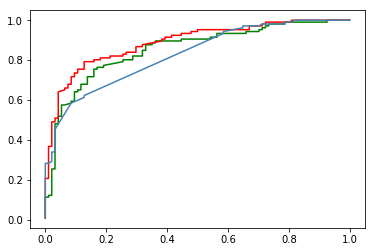

In [67]:
from sklearn.metrics import roc_auc_score,roc_curve
from sklearn.metrics import auc
import matplotlib.pyplot as plt
probs1 = pd.DataFrame(model1.predict_proba(test_x),columns=['Neg_1','Pos_2'])
fpr,tpr,cutoffs = roc_curve(test_y,probs1['Pos_2'],pos_label='1')
auc_rf =auc(fpr,tpr)
plt.plot(fpr,tpr,color='green')
print('Multinomian NB AUC: %.2f' % auc_rf)

probs2 = pd.DataFrame(model2.predict_proba(test_x),columns=['Neg_1','Pos_2'])
fpr,tpr,cutoffs = roc_curve(test_y,probs2['Pos_2'],pos_label='1')
auc_ab =auc(fpr,tpr)
plt.plot(fpr,tpr,color='red')
print('Random Forest AUC: %.2f' % auc_ab)

probs3 = pd.DataFrame(model3.predict_proba(test_x),columns=['Neg_1','Pos_2'])
fpr,tpr,cutoffs = roc_curve(test_y,probs3['Pos_2'],pos_label='1')
auc_dt=auc(fpr,tpr)
plt.plot(fpr,tpr,color='steelblue')
print('AdaBoost Classifier AUC: %.2f' % auc_dt)

# Sentiment using vader package

In [46]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sentiment = SentimentIntensityAnalyzer()
def get_sentiment(doc):
    score = sentiment.polarity_scores(doc)['compound']
    if(score>0):
        return 1
    else:
        return 0
sent_pred =data['review'].apply(get_sentiment)
print(accuracy_score(data['sentiment'],sent_pred))

0.812


# Topic modelling

In [68]:
import gensim

In [76]:
docs = data['review'].fillna('').str.lower().str.replace('[^a-z ]', '')
stopwords = nltk.corpus.stopwords.words('english')
stopwords.extend(['','use', 'good', 'like', 'great'])
stemmer = nltk.stem.PorterStemmer()
docs_clean=[]
for doc in docs:
    words=doc.split(' ')
    words_clean = [stemmer.stem(word) for word in words if word not in stopwords]
   
    docs_clean.append(words_clean)
len(docs_clean)

1000

In [77]:
dictionary = gensim.corpora.Dictionary(docs_clean)
dictionary

In [78]:
docs_bow = []
for doc in docs_clean:
    doc_bow = dictionary.doc2bow(doc)
    docs_bow.append(doc_bow)

In [79]:
lda_model = gensim.models.LdaModel(docs_bow,
                                  id2word = dictionary,
                                  num_topics = 4)

- Here we will select the number of topics by seeing the topics whether they are having similar words in that document

In [80]:
lda_model.get_document_topics(docs_bow[0])

[(0, 0.06387788), (1, 0.07470739), (2, 0.7964147), (3, 0.06500005)]

In [81]:
lda_model.get_document_topics(docs_bow[1])

[(0, 0.13696161), (1, 0.61255556), (2, 0.12523808), (3, 0.12524477)]

In [115]:
lda_model.print_topics()

[(0,
  '0.018*"back" + 0.015*"food" + 0.013*"go" + 0.010*"time" + 0.010*"one" + 0.009*"tast" + 0.008*"wont" + 0.007*"would" + 0.007*"way" + 0.006*"ever"'),
 (1,
  '0.040*"place" + 0.009*"realli" + 0.007*"go" + 0.007*"time" + 0.007*"dont" + 0.007*"best" + 0.007*"nice" + 0.006*"star" + 0.006*"restaur" + 0.006*"eat"'),
 (2,
  '0.039*"food" + 0.018*"servic" + 0.009*"place" + 0.009*"love" + 0.007*"time" + 0.007*"came" + 0.007*"im" + 0.007*"delici" + 0.006*"eat" + 0.006*"realli"'),
 (3,
  '0.019*"servic" + 0.012*"place" + 0.011*"back" + 0.010*"go" + 0.009*"food" + 0.008*"steak" + 0.008*"time" + 0.008*"well" + 0.007*"wait" + 0.007*"never"')]

In [82]:
doc2topic_prob = lda_model.get_document_topics(docs_bow[0])

doc2topic_prob = pd.DataFrame(doc2topic_prob, columns=['topic','prob'])

doc2topic_prob.sort_values('prob', ascending = False).iloc[0]['topic']

2.0

In [98]:
topics = []
for doc_bow in docs_bow:
    doc2topic_prob = lda_model.get_document_topics(doc_bow)
    doc2topic_prob = pd.DataFrame(doc2topic_prob, columns=['topic','prob'])
    topic = doc2topic_prob.sort_values('prob', ascending = False).iloc[0]['topic']
    topics.append(topic)

In [101]:
data['topics'] = topics
topic_count =data['topics'].value_counts()
topic_count=pd.DataFrame(topic_count).reset_index()
topic_count


,index,topics
0,2.0,286
1,1.0,241
2,0.0,239
3,3.0,234


# Bar chart

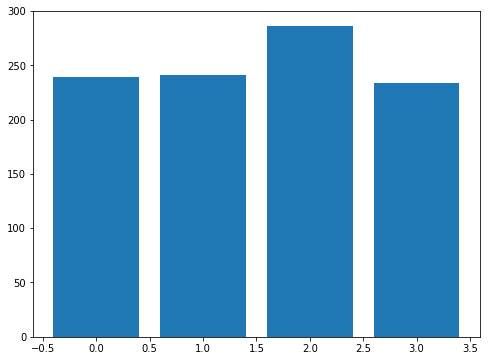

In [111]:
fig = plt.figure(figsize=(8,6))
plt.bar((topic_count['index']),topic_count['topics'])
plt.show()